# DSE Course 2, Session 3: Unsupervised Learning: Clustering, Dimensionality Reduction

**Instructor**: Wesley Beckner

**Contact**: wesleybeckner@gmail.com

<br>

---

<br>

In the previous session we began our discussion on feature engineering and ended with a sneak peak into dimensionality reduction. This last topic deserves a whole session on its own because its use case is not limited to feature engineering! It can also be used as a tool for visualization, for noise filtering, and much more. In this session we discuss dimensionality reduction along with other unsupervised learning methods. 

Up until now, the only learning estimators we've looked at were supervised ones: estimators that predict labels based on training data. Here, however, we are interested in uncovering aspects of the data without reference to any known labels. The usefulness for these learners will become immediately apparent when we revist our wine quality models from Course 1, Session 7!

<br>

---

<br>

<a name='top'></a>

# Contents

* 3.0 [Preparing Environment and Importing Data](#3.0)
  * 3.0.1 [Import Packages](#x.0.1)
  * 3.0.2 [Load Dataset](#x.0.2)
* 3.1 [Principal Component Analysis](#3.1)
  * 3.1.1 [Introduction to PCA](#x.1.1)
  * 3.1.2 [PCA as Dimensionality Reduction](#3.1.1)
  * 3.1.3 [PCA for visualization](#3.1.2)
  * 3.1.4 [Enrichment: PCA as Noise Filtering](#3.1.3)
  * 3.1.5 [PCA for Feature Engineering](#3.1.4)
* 3.2 [K-Means Clustering](#3.2)
  * 3.2.1 [The Algorithm: Expectation-Maximization](#3.2.1)
  * 3.2.2 [Limitations](#3.2.2)
* 3.3 [Gaussian Mixture Models](#3.3)
  * 3.3.1 [Generalizing E-M for GMMs](#3.3.1)
  * 3.3.2 [GMMs as a Data Generator](#3.3.2)
    * 3.3.2.1 [Determining the Number of Components](#x.3.2.1)
* 3.4 [K-Nearest Neighbors](#x.4)

<br>

---

<a name='3.0'></a>

## 3.0 Preparing Environment and Importing Data

[back to top](#top)

<a name='x.0.1'></a>

### 3.0.1 Import Packages

[back to top](#top)

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import random
import scipy.stats
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.mixture import GaussianMixture
import seaborn as sns; sns.set()
import copy

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



<a name='x.0.2'></a>

### 3.0.2 Load Dataset

[back to top](#top)

In [3]:
wine = pd.read_csv("https://raw.githubusercontent.com/wesleybeckner/"\
      "ds_for_engineers/main/data/wine_quality/winequalityN.csv")

In [4]:
wine.dropna(inplace=True)
wine['quality_label'] = wine['quality'].apply(lambda x: 'low' if x <=5 else
                                              'med' if x <= 7 else 'high')

wine['type_encoding'] = wine['type'].map({'red': 0, 'white': 1})
wine['quality_encoding'] = wine['quality_label'].map({'low':0, 
                                                      'med': 1, 'high': 2})

wine.columns = wine.columns.str.replace(' ', '_')

features = list(wine.columns[1:-1].values)
# features.remove('type_encoding')
features.remove('quality_label')
features.remove('quality')

# since we use density as a target in some of the examples I'm
# going to make a feature list that doesn't include density
non_density = copy.copy(features)
non_density.remove('density')

<a name='3.1'></a>

## 3.1 Principal Component Analysis

[back to top](#top)

Principle Component Analysis or PCA is one of the most wide spread implementations of dimensionality reduction. In PCA, we find the principle components, or linear recombinations of the dimensions of the data, that best explain the variance of the data. 

There are mathematical arguments abound for describing how we analytically solve for the principle components and how they relate to other concepts in mathematics (like pythagorean theorem). We'll sidestep that conversation for now, and proceed to our pragmatic demonstrations, as we have done in the past.

<a name='x.1.1'></a>

### 3.1.1 Introduction to PCA

[back to top](#top)

In the cell below, we have plotted acidity and density from our familiar wine dataset.

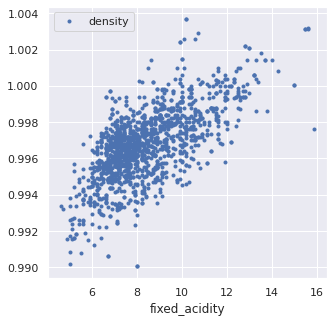

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
wine.loc[wine['type'] == 'red'].plot(x='fixed_acidity', 
                                     y='density', 
                                     ax=ax, 
                                     ls='', marker='.')

In [6]:
X = wine.loc[wine['type'] == 'red'][['fixed_acidity', 'density']].values
X[:5]

array([[ 7.4   ,  0.9978],
       [ 7.8   ,  0.9968],
       [ 7.8   ,  0.997 ],
       [11.2   ,  0.998 ],
       [ 7.4   ,  0.9978]])

The principal components, are actually the eigenvectors of the covariance matrix of the standardized data. 

We will perform this by hand to get an understanding.

First we standardize the data

In [7]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

Then we compute the covariance matrix. There is a nice demonstration of computing covariance on [stats quest](https://www.youtube.com/watch?v=qtaqvPAeEJY).

The covariance can be expressed as:

$$ cov(X,Y) = \frac{1}{n^2}\sum\sum(x_i - x_j)(y_i - y_j) $$

Every $(x_i - x_j)(y_i - y_j) $ is the area described by the rectangle between points $i$ and $j$, and we if we deem to color positive changes as red and negative ones as blue, we get a picture like the following: 


<p align=center>
<img src="https://i.stack.imgur.com/XPGjN.png"></img>

When we view all the pairwise interactions in aggregate we get a sense of how the areas of rectangles made by each observation influence the covariance:

<p align=center>
<img src="https://i.stack.imgur.com/Kfmhn.png"></img>

As a side note, the covariance term is the numerator in the pearsons correlation we covered last week:

$$\rho_{x,y} = \frac{cov(X,Y)}{\sigma_x\sigma_y}$$


In [8]:
import numpy as np
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

Covariance matrix 
[[1.00062814 0.66831213]
 [0.66831213 1.00062814]]


The principal components are found mathematically by determining the eigenvectors of the covariance matrix and sorting them by their egienvalues, or their explained variance. 

There is a mathematical proof [1](https://stats.stackexchange.com/questions/217995/what-is-an-intuitive-explanation-for-how-pca-turns-from-a-geometric-problem-wit), [2](https://stats.stackexchange.com/questions/10251/what-is-the-objective-function-of-pca/10256#10256) for why this works, but we will not cover that here. 

In [9]:
cov_mat = np.cov(X_std.T)

# we can solve for the eigenvalues/vectors of our covariance
# matrix using numpy!
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[-0.70710678 -0.70710678]
 [ 0.70710678 -0.70710678]]

Eigenvalues 
[0.33231601 1.66894027]


And now we are just going to sort our vectors by their eigenvalues to get the proper order of principal components:

In [10]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
1.6689402736104237
0.33231600779661163


For those of us who are familiar with eigenvectors, we should recognize that they are necessarily orthogonal to one another. This is good to know from the PCA point of view, because we wouldn't want the variance along one vector to be explained by another. Let's plot these vectors along with the standardized data:

(-2.141423705153984, 4.352327069615032)

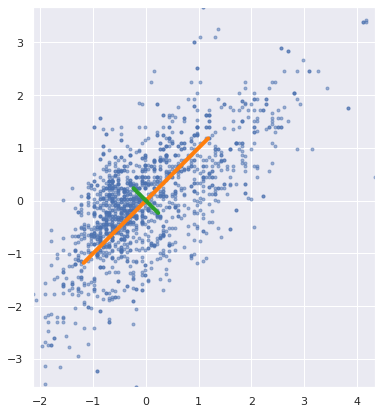

In [11]:
fig, ax = plt.subplots(1,1,figsize=(7,7))

ax.plot(X_std[:,0],X_std[:,1],ls='',marker='.', alpha=0.5)

for vec, color in zip(range(eig_vecs.shape[0]),['orange', 'green']):

  ax.plot([np.mean(X_std[:,0]),
           (eig_pairs[vec][1][0]+np.mean(X_std[:,0]))*-eig_pairs[vec][0]],
          [np.mean(X_std[:,1]),
           (eig_pairs[vec][1][1]+np.mean(X_std[:,1]))*-eig_pairs[vec][0]],
          color=f'tab:{color}', linewidth=4)
  
  ax.plot([np.mean(X_std[:,0]),
           (eig_pairs[vec][1][0]+np.mean(X_std[:,0]))*eig_pairs[vec][0]],
          [np.mean(X_std[:,1]),
           (eig_pairs[vec][1][1]+np.mean(X_std[:,1]))*eig_pairs[vec][0]],
          color=f'tab:{color}', linewidth=4)
  
ax.set_aspect('equal')
ax.set_ylim(min(X_std[:,1]),max(X_std[:,1]))
ax.set_xlim(min(X_std[:,0]),max(X_std[:,0]))

[grandparent, spouse, daughter parable](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues/140579#140579)

We indeed see that these vectors are orthogonal

In [12]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

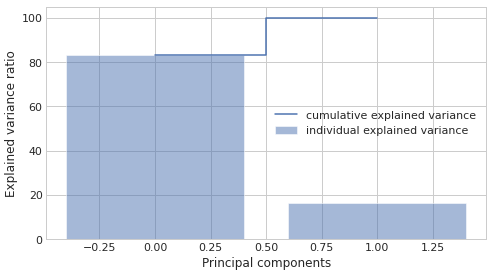

In [13]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(7, 4))

    plt.bar(range(2), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(2), cum_var_exp, where='mid',
             label='cumulative explained variance')
    
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='center right')
    plt.tight_layout()

Here I'm just putting my eigenvectors into the proper shape:

In [14]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(2,1),
                      eig_pairs[1][1].reshape(2,1)))

print('Matrix W:\n', matrix_w)

Matrix W:
 [[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]


In order to take the dot product, project, `X_std` onto the first two principal components:

In [15]:
Y = X_std.dot(matrix_w)

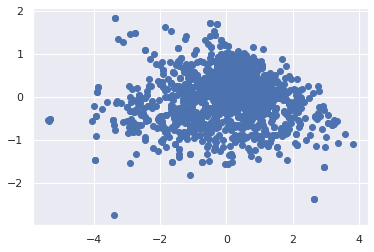

In [16]:
plt.scatter(Y[:,0],Y[:,1])

But we can avoid the fancy footwork and do all this in sklearn!

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_std)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

We see that the values we get are the same as for the hand-calculated eigenvalues and vectors

In [18]:
print(pca.components_)

[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]


And the eigenvalues are under `pca.explained_variance_`

In [19]:
print(pca.explained_variance_)

[1.66894027 0.33231601]


<a name='3.1.1'></a>

### 3.1.2 PCA as Dimensionality Reduction

[back to top](#top)

One obvious use case for PCA, is to drop the dimensions with lowest explained variance. Continuing with our acidity/density example this will look like the following

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_std)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

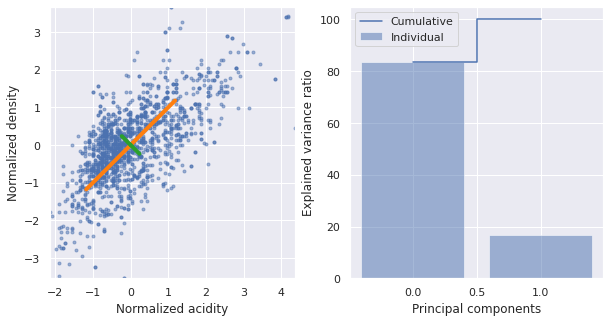

In [21]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(X_std[:,0],X_std[:,1],ls='',marker='.', alpha=0.5)

for vec, color in zip(range(eig_vecs.shape[0]),['orange', 'green']):

  ax[0].plot([np.mean(X_std[:,0]),
           (eig_pairs[vec][1][0]+np.mean(X_std[:,0]))*-eig_pairs[vec][0]],
          [np.mean(X_std[:,1]),
           (eig_pairs[vec][1][1]+np.mean(X_std[:,1]))*-eig_pairs[vec][0]],
          color=f'tab:{color}', linewidth=4)
  
  ax[0].plot([np.mean(X_std[:,0]),
           (eig_pairs[vec][1][0]+np.mean(X_std[:,0]))*eig_pairs[vec][0]],
          [np.mean(X_std[:,1]),
           (eig_pairs[vec][1][1]+np.mean(X_std[:,1]))*eig_pairs[vec][0]],
          color=f'tab:{color}', linewidth=4)
  
ax[0].set_aspect('equal')
ax[0].set_ylim(min(X_std[:,1]),max(X_std[:,1]))
ax[0].set_xlim(min(X_std[:,0]),max(X_std[:,0]))
ax[0].set_ylabel('Normalized density')
ax[0].set_xlabel('Normalized acidity')

ax[1].bar(range(2), var_exp, alpha=0.5, align='center',
        label='Individual')
ax[1].step(range(2), cum_var_exp, where='mid',
          label='Cumulative')

ax[1].set_ylabel('Explained variance ratio')
ax[1].set_xlabel('Principal components')
ax[1].legend()

We can capture 80% of the explained variance along just the first principal component. What does this projection look like?

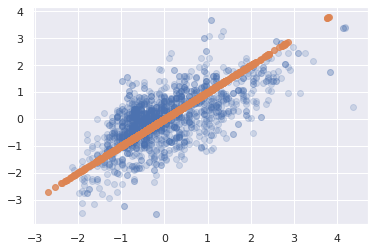

In [22]:
# we set our components to 1
pca = PCA(n_components=1)
pca.fit(X_std)

# we then project the data onto the first PC
# and then rebroadcast this transformation 
# back onto the orginal dimensions to see 
# what this looks like in terms of acidity/density
X_pca = pca.inverse_transform(pca.transform(X_std))

# original data
plt.scatter(X_std[:, 0], X_std[:, 1], alpha=0.2)

# projected data
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.8)

<a name='3.1.2'></a>

### 3.1.3 PCA for visualization

[back to top](#top)

For classification tasks, PCA lends itself as a useful method for seeing how the classes separate on the highest variance dimensions of the data without consideration to the classes themselves, i.e. do our classes seperate out according to the other variables in the dataset.

With our wine dataset, we see that the wine types fall out nicely along the first two principal components

Text(0, 0.5, 'Second PC')

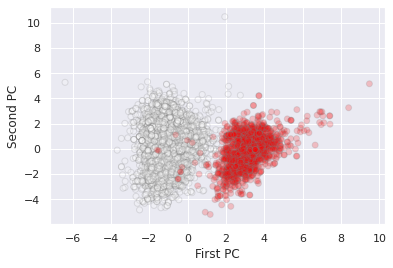

In [23]:
X = wine.select_dtypes(exclude=['object']).values
X_std = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
pca.fit(X_std)
X_pca = pca.transform(X_std)

plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2, c=wine['type'].values,
            edgecolor='grey')
plt.xlabel('First PC')
plt.ylabel('Second PC')

<a name='3.1.3'></a>

### 3.1.4 Enrichment: PCA as Outlier Removal and Noise Filtering

[back to top](#top)

In some cases, it can be advantageous to use PCA as a method for outlier removal. There are many caveats to this that we will not discuss here. But for those who are interested, [this](https://towardsdatascience.com/multivariate-outlier-detection-in-high-dimensional-spectral-data-45878fd0ccb8) is a great overview article. As for noise filteration, [Vanderplas' DS handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html#PCA-as-Noise-Filtering) has a good section on the topic as does [Guido/Muller's Intro to ML with Python](https://www.oreilly.com/library/view/introduction-to-machine/9781449369880/) by the same pusblisher.

<a name='3.1.4'></a>

### 3.1.5 PCA for Feature Engineering

[back to top](#top)

Finally, PCA is actually a commonly used preprocessing technique for supervised machine learning models. In the next exercise, our goal will be to use PCA to generate a new set of features, to feed into our linear model.

#### 3.1.5.1 Exercise: PCA as Preprocessing for Models

Using the wine data, select any number of the first principal components and attemp to predict density for the red wine data.

0.6724220226959543

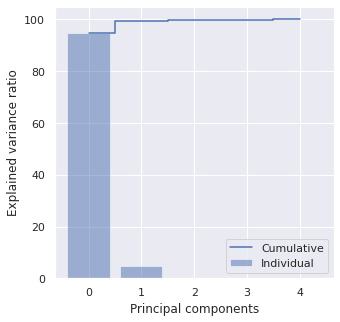

In [48]:
# Code Cell for Exercise 3.1.5.1
red = wine.loc[wine['type'] == 'red']
comp = 5
pca = PCA(n_components=comp)
X_pca = pca.fit_transform(red.loc[:,non_density])

tot = sum(pca.explained_variance_)
var_exp = [(i / tot)*100 for i in sorted(pca.explained_variance_, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.bar(range(comp), var_exp, alpha=0.5, align='center',
        label='Individual')
ax.step(range(comp), cum_var_exp, where='mid',
          label='Cumulative')

ax.set_ylabel('Explained variance ratio')
ax.set_xlabel('Principal components')
ax.legend()

X_pca = pd.DataFrame(X_pca)

model = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X_pca, red['density'],
                                      test_size=0.20, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2_score(y_pred,y_test)

<a name='3.2'></a>

## 3.2 K-Means Clustering

[back to top](#top)

We now embark on a second class of unsupervised learning techinques: clustering. 

The K-means algorithm works under two assumptions: 
  * every cluster can be defined by an arithmetic mean or cluster center
  * each point is closer to one arithmetic center than the other centers

Let's turn back to our wine dataset:

Text(0, 0.5, 'Second PC')

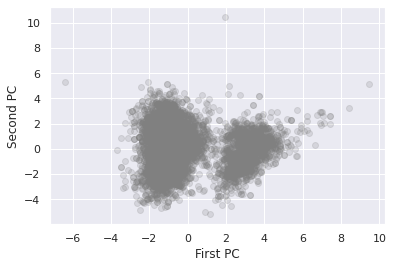

In [25]:
X = wine.select_dtypes(exclude=['object']).values
X_std = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
pca.fit(X_std)
X_pca = pca.transform(X_std)

plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2, c='grey')
plt.xlabel('First PC')
plt.ylabel('Second PC')

It is fairly obvious under these two dimensions that there are two clusters. The K-means algorithm automatically pics this out

In [26]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_pca)
y_kmeans = kmeans.predict(X_pca)

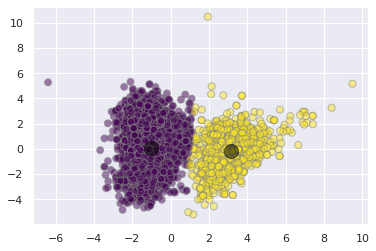

In [27]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, s=50, 
            alpha=0.5, edgecolor='grey', cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

wa-la! Our simple unsupervised algorithm does a pretty good job of differentiating between the red and white wine clusters.

<a name='3.2.1'></a>

### 3.2.1 The Algorithm: Expectation-Maximization

[back to top](#top)

We won't go too far into the implementation of the underlying algorithm here. In its basic steps, however, it performs the following:

1. Initialize cluster centers (random guess)
2. Then repeat:
  1. E-Step: assign points to the nearest center (arithmetic distance)
  2. M-step: set the new center point for each cluster according to the mean of it's datapoint members

More information on K-means algorithm can be explored [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html#k-Means-Algorithm:-Expectation%E2%80%93Maximization)

<a name='3.2.2'></a>

### 3.2.2 Limitations

[back to top](#top)

A few brief notes on limitations:

1. the global optimum may not be achieved (no guarantee of finding the overall best solution)
2. the number of clusters must be guessed beforehand
3. cluster boundaries are unavoidably linear
  * and the cluster assignments are unavoidably circular
4. can be slow for large datasets
5. cluster assignments are non probabilistic

3 and 5 motivate our next section, Gaussian Mixture Models

<a name='3.3'></a>

## 3.3 Gaussian Mixture Models

[back to top](#top)

in the simplest case, GMMs can be used in the same way as K-means



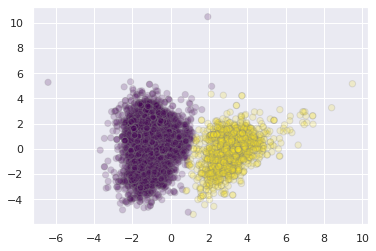

In [28]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2).fit(X_pca)
labels = gmm.predict(X_pca)
plt.scatter(X_pca[:, 0], X_pca[:, 1], 
            c=labels, s=40, cmap='viridis',
            alpha=0.2, edgecolor='grey');

But because GMM is a probablistic model, we can visualize the certainty with which we assign these clusters.

In [29]:
probs = gmm.predict_proba(X_pca)
print(probs[5:20].round(3))

[[1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [0.992 0.008]
 [1.    0.   ]
 [0.99  0.01 ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [0.999 0.001]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]]


In [30]:
# convert probs to 1 dimension
probs.max(1)

array([1.        , 0.99985029, 0.99996753, ..., 0.99997744, 0.99999985,
       0.98796517])

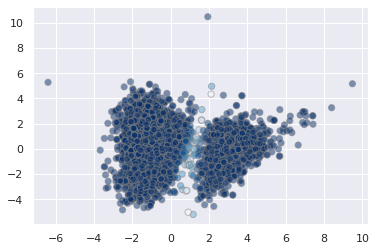

In [31]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], 
            c=probs.max(1), s=40, cmap='Blues',
            alpha=0.5, edgecolor='grey');

<a name='3.3.1'></a>

### 3.3.1 Generalizing E-M for GMMs

[back to top](#top)

The algorithm for GMMs is very similar to K-means, but now the EM steps are probablistic [1](https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95) [2](https://www.deep-teaching.org/notebooks/graphical-models/directed/exercise-1d-gmm-em)

1. Initialize cluster centers (random guess)
2. Then repeat:
  1. E-Step: assign points their probability of belonging to every cluster
  2. M-step: set the new center point for each cluster according to the probabilities of *all* datapoints


<a name='3.3.2'></a>

### 3.3.2 GMMs as a Data Generator

[back to top](#top)

One particularly fascinating application of GMMs is to use them to generate new data that is similar to the data on which they are modeled. Let's take an example.

We're going to use sklearn make_circles function to create some arbitrary data that has a complex relationship along two different axes.



In [32]:
# some helper functions borrowed from Jake Vanderplas with a few minor tweaks
# https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None, data_alpha=1):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2,
                   alpha=data_alpha)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2, alpha=data_alpha)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

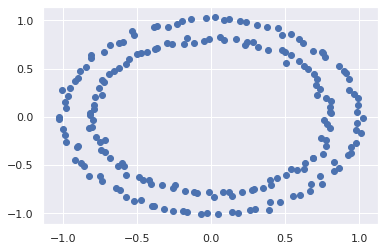

In [33]:
from sklearn.datasets import make_circles as gen
X, y = gen(200, noise=0.02, random_state=42)
plt.scatter(X[:, 0], X[:, 1]);

As a side note, as a clustering model, the GMM is not particularly useful:

In [34]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)

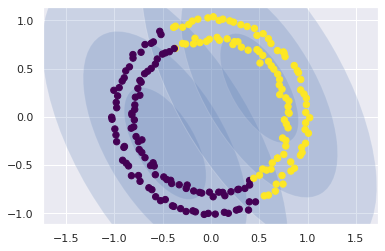

In [35]:
plot_gmm(gmm2, X)

But if we use the GMM as a density estimator on the underlying data, rather than as a clustering algorithm, we find a completely different use case:

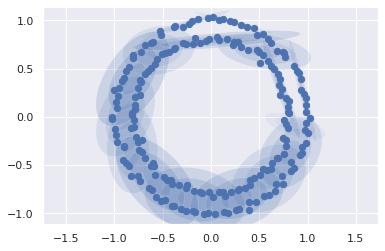

In [36]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, X, label=False)

Now, with the distributions drawn, we can assemble entirely new data:

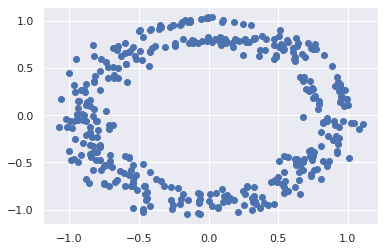

In [37]:
Xnew = gmm16.sample(400)[0]
plt.scatter(Xnew[:, 0], Xnew[:, 1]);

<a name='x.3.2.1'></a>

#### 3.3.2.1 Determining the number of components

[back to top](#top)

Let's think back to session 1 on model selection. How might we determine the best number of components?

A couple analytic approaches that we have not much yet discussed, are the **Akaike Information Criterion (AIC)** and **Bayesian Information Criterion (BIC).** The important thing to note from each of these is that they penalize added complexity to the models, and we would like to minimize their estimated prediction error.

Text(0, 0.5, 'est. prediction error')

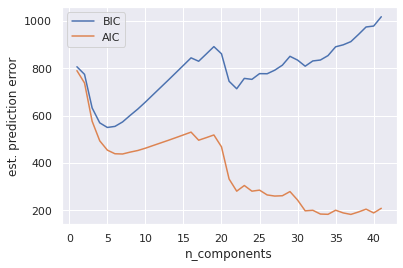

In [38]:
n_components = np.arange(1, 42)
models = [GaussianMixture(n, covariance_type='full', random_state=42).fit(X)
          for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');
plt.ylabel('est. prediction error')

Both AIC and BIC capture a local minimum on the order of 6 Gaussians. This is where the model captures the overall circular modality of the data. However it totally misses the circumscribed nature of the two circles. Increasing this number to 30-40 gaussians captures this feature of the data. The AIC score reflects this while the BIC score (although captures a local minima in the area) does not define this as a global optimum.

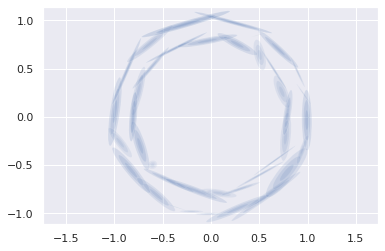

In [39]:
gmmNew = GaussianMixture(n_components=40, covariance_type='full', random_state=0)
plot_gmm(gmmNew, X, label=True, data_alpha=0)

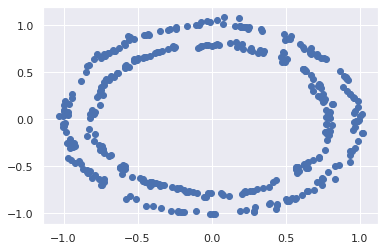

In [40]:
Xnew = gmmNew.sample(400)[0]
plt.scatter(Xnew[:, 0], Xnew[:, 1]);

#### 3.3.2.2 Exercise: Determine Number of Components for Circular Moons

Repeat the above, this time using `sklearn.datasets.make_moons`

Text(0, 0.5, 'est. prediction error')

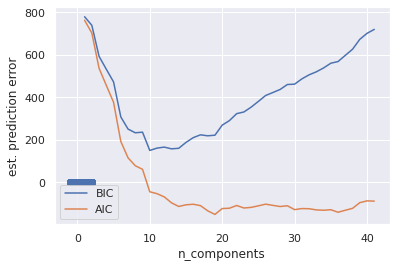

In [41]:
# Code Cell for Exercise 3.3.2.2

from sklearn.datasets import make_moons as gen
X, y = gen(200, noise=0.02, random_state=42)
plt.scatter(X[:, 0], X[:, 1]);

n_components = np.arange(1, 42)
models = [GaussianMixture(n, covariance_type='full', random_state=42).fit(X)
          for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');
plt.ylabel('est. prediction error')

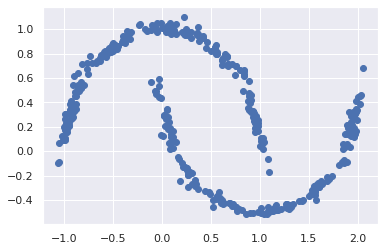

In [42]:
Xnew = models[10].sample(400)[0]
plt.scatter(Xnew[:, 0], Xnew[:, 1]);

# References

## PCA

* [Intuitive PCA](https://stats.stackexchange.com/questions/217995/what-is-an-intuitive-explanation-for-how-pca-turns-from-a-geometric-problem-wit)

* [PCA and Eigenvectors/values](https://stats.stackexchange.com/questions/10251/what-is-the-objective-function-of-pca/10256#10256)

## GMM

* [GMMs Explained](https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95) 

* [Derive GMM Exercise](https://www.deep-teaching.org/notebooks/graphical-models/directed/exercise-1d-gmm-em)